In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pylab import *

import numpy as np
import pyemma
import pytraj as pt
import mdtraj as md

import pickle
import seaborn as sns

from pyemma.util.contexts import settings
from glob import glob

## Loading data

In [2]:
rf0=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot0.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7')

rf1=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot1.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.parm7')

rf2=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot2.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.parm7')

rf3=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot3.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.parm7')

rf4=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot4.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.parm7')

rf5=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot5.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.parm7')

rfopen=pt.load('../1-Trajectories/0-Parm_rst/open10_dry.rst7',
               '../1-Trajectories/0-Parm_rst/open10_dry.parm7')

In [5]:
indir1 = '../1-Trajectories/1-NoEq_without_IPA'
indir2 = '../1-Trajectories/3-Adaptive_sampling_without_IPA'
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'

traj_list1 = sorted(glob(indir1+'/*.nc'))
traj_list2 = sorted(glob(indir2+'/*.nc'))

traj_list=traj_list1 # +traj_list2
traj_list

['../1-Trajectories/1-NoEq_without_IPA/closed_dry_01.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_02.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_03.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_04.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_05.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_06.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_07.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_08.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_09.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_10.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_01.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_02.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_03.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_04.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_05.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_06.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_07.nc',
 '../1-Trajectories/1-NoEq_w

In [6]:
refclosed=md.load(['../1-Trajectories/0-Parm_rst/closed6_dry_rot0.rst7', 
                   '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.rst7',
                   '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.rst7', 
                   '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.rst7', 
                   '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.rst7', 
                   '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.rst7'], 
                  top='../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7')

refopen=md.load('../1-Trajectories/0-Parm_rst/open10_dry.rst7', 
                top='../1-Trajectories/0-Parm_rst/open10_dry.parm7')

In [7]:
BB=[atom.index for atom in refopen.topology.atoms if atom.is_backbone]

In [8]:
def min_min_rmsd(traj):
    return np.array([md.rmsd(traj, refclosed, frame=n, atom_indices=BB)
                     for n in range(refclosed.n_frames)]).min(axis=0)[:, np.newaxis]

In [9]:
rmsd_feat = pyemma.coordinates.featurizer(topfile)
rmsd_feat.add_custom_func(min_min_rmsd, 1)
rmsd_feat.add_minrmsd_to_ref(refopen, atom_indices=BB)
rmsd_data = pyemma.coordinates.load(traj_list, features=rmsd_feat)
labels = ['backbone\nrmsd']

In [10]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.
    
    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.
    
    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    #with pyemma.util.contexts.settings(show_progress_bars=False):
    nval = int(len(data) * validation_fraction)
    scores = np.zeros(number_of_splits)
    for n in range(number_of_splits):
        ival = np.random.choice(len(data), size=nval, replace=False)
        vamp = pyemma.coordinates.vamp(
            [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
        scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

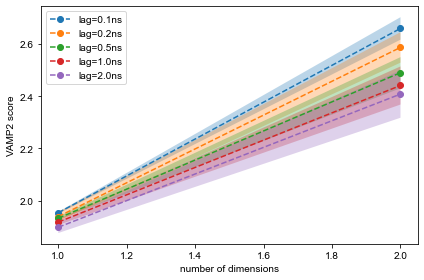

In [11]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(2)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(rmsd_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [12]:
tica = pyemma.coordinates.tica(rmsd_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

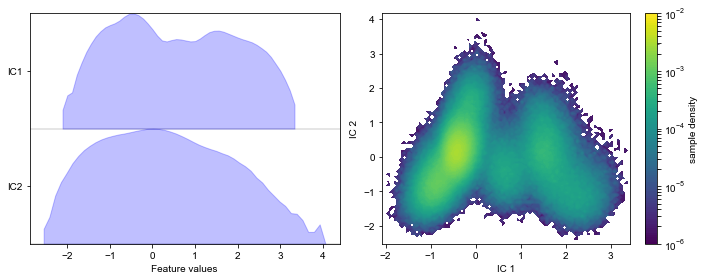

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

In [14]:
Y=tica_output
Y_concat=tica_concatenated

In [15]:
n_clustercenters = [10, 100, 200, 300, 400, 500, 600, 800]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=True):
            _cl = pyemma.coordinates.cluster_kmeans(
                Y, k=k, max_iter=500, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

Text(0, 0.5, 'VAMP-2 score')

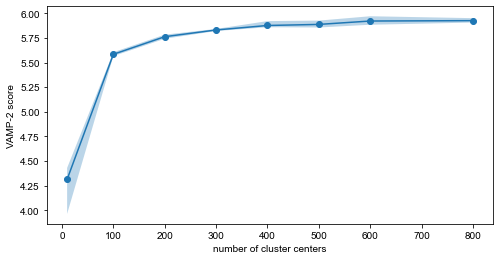

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
# ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')

In [18]:
cluster_400 = pyemma.coordinates.cluster_kmeans(
    Y, k=400, max_iter=100, stride=10)

dtrajs_concatenated_400 = np.concatenate(cluster_400.dtrajs)

In [20]:
mylags = [1,2,5,10,25,50,100,200,300,400,500,600,700,800,900,1000,
          1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4500,5000,
          5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]

its_400 = pyemma.msm.its(cluster_400.dtrajs, lags=mylags, nits=10, errors='bayes')
with open('./pickled/2-Without_IPA/1_its_tica_400.pickle', 'wb') as outf:
    pickle.dump(its_400, outf)

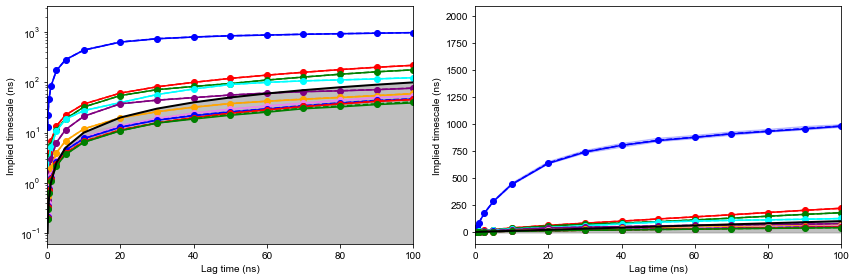

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

pyemma.plots.plot_implied_timescales(its_400,ax=axes[0],units='ns', dt=0.1, ylog=True);
pyemma.plots.plot_implied_timescales(its_400,ax=axes[1],units='ns', dt=0.1, ylog=False);

axes[0].set_xlabel("Lag time (ns)")
axes[1].set_xlabel("Lag time (ns)")

axes[0].set_ylabel("Implied timescale (ns)")
axes[1].set_ylabel("Implied timescale (ns)")

axes[0].set_xlim(0,100)
axes[1].set_xlim(0,100)


plt.tight_layout()

In [26]:
msm = pyemma.msm.bayesian_markov_model(cluster_400.dtrajs, lag=300, dt_traj='0.1 ns')

In [27]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt((ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

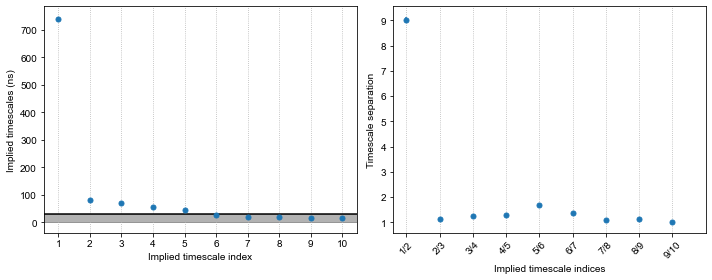

In [28]:
nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('Implied timescale index')
axes[0].set_ylabel('Implied timescales (ns)')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits )],rotation=45)
axes[1].set_xlabel('Implied timescale indices')
axes[1].set_ylabel('Timescale separation')

plt.tight_layout()

Text(0, 0.5, 'RMSD to open crystal structure ($\\AA$)')

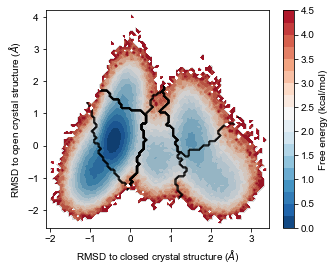

In [35]:
nstates=6
msm.pcca(nstates)

dtrajs_concatenated = np.concatenate(cluster_400.dtrajs)
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

black_cmap = ListedColormap(["k","k","k","k","k","k"])

diverging_colors = sns.color_palette("RdBu_r", 19)
sns_cmap = ListedColormap(diverging_colors[0:18])


fig, ax = plt.subplots(figsize=(5, 4))


pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T, 
#     weights=np.concatenate(msm.trajectory_weights()),
    ax=ax, nbins=100,
    kT=0.5825, legacy=False, alpha=1, cmap=sns_cmap,
#     vmin=0.0, vmax=5.0, 
    levels=19,
    cbar_label="Free energy (kcal/mol)"
)

_, _, misc = pyemma.plots.plot_state_map(
    *Y_concat.T, metastable_traj, ax=ax, alpha=0.15, nbins=100, cbar=False,cmap=black_cmap)


ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')
# ax.set_aspect('equal')
# ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

# ax.set_xticks(np.arange(0, 5, 0.5))
# ax.set_yticks(np.arange(0, 5, 0.5))
# plt.tight_layout()

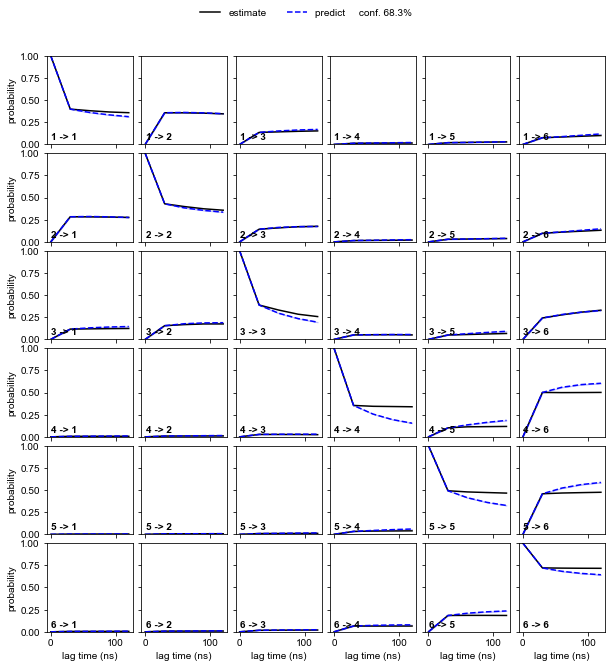

In [36]:
nstates=6
cktest_msm = msm.cktest(nstates, mlags=5, conf=0.6827)

pyemma.plots.plot_cktest(cktest_msm, dt=0.1, units='ns');

## RMSD 'features'

In [ ]:
results_open=[]
results_closed=[]
for t in traj_list:
    traj=pt.load(t, topfile, stride=1)
    rmsd0=pt.rmsd(traj,ref=rf0, mask="@CA,N,C,O")
    rmsd1=pt.rmsd(traj,ref=rf1, mask="@CA,N,C,O")
    rmsd2=pt.rmsd(traj,ref=rf2, mask="@CA,N,C,O")
    rmsd3=pt.rmsd(traj,ref=rf3, mask="@CA,N,C,O")
    rmsd4=pt.rmsd(traj,ref=rf4, mask="@CA,N,C,O")
    rmsd5=pt.rmsd(traj,ref=rf5, mask="@CA,N,C,O")
    
    rmsd_closed=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)
    results_closed.append(rmsd_closed)
    
    rmsd_open=pt.rmsd(traj,ref=rfopen, mask="@CA,N,C,O")
    results_open.append(rmsd_open)

Create a Y matrix similar to that optained with PyEMMA after TICA analysis

In [ ]:
Y=[]
for i in range(0,len(results_open)):  
    Z=[]
    for j in range(0,len(results_open[i])):
        a=np.array([results_closed[i][j],results_open[i][j]])
        Z.append(a)
    Z=np.array(Z)
    Y.append(Z)
print(len(Y))
print(len(Y[0]))
print(len(Y[0][0]))

In [ ]:
tot=0
for i in range(0,len(Y)):
    tot+=len(Y[i])
print("simulated time:", tot/10000, "microseconds")

In [4]:
# with open('./pickled/2-Without_IPA/1_Y.pickle', 'wb') as outf:
#     pickle.dump(Y, outf)
    
with open('./pickled/2-Without_IPA/1_Y.pickle', 'rb') as inf:
    Y = pickle.load(inf)

In [5]:
Y_concat= np.concatenate(Y)

In [6]:
tot=0
for i in range(0,len(Y)):
    print(len(Y[i])/10000, "microseconds")
    tot+=len(Y[i])
print("simulated time:", tot/10000, "microseconds")

2.434 microseconds
2.4446 microseconds
2.5 microseconds
2.5 microseconds
2.5 microseconds
2.5 microseconds
3.5 microseconds
3.5 microseconds
3.5 microseconds
3.5 microseconds
2.5 microseconds
2.371 microseconds
2.5 microseconds
2.5 microseconds
2.4372 microseconds
2.5 microseconds
2.5 microseconds
3.5 microseconds
2.5 microseconds
2.5 microseconds
simulated time: 54.6868 microseconds


## Density and initial FES

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    Y_concat,
    ax=axes[0],
    feature_labels=[r'RMSD to closed', r'RMSD to open'],
    ylog=False, color="midnightblue")


axes[0].set_xlabel(r'RMSD ($\AA$)')

axes[0].set(xlim=(0,4.5))

axes[0].set_xticks(np.arange(0, 5, 0.5))

pyemma.plots.plot_density(*Y_concat[:, :2].T, ax=axes[1], logscale=False, nbins=100, alpha=1)

axes[1].scatter(x=0.0, y=3.1458, s=20, c="midnightblue", marker="s")
axes[1].scatter(x=3.1458, y=0.0, s=20, c="midnightblue", marker="s")

axes[1].set_aspect('equal')
axes[1].text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
axes[1].text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

axes[1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1].set_ylabel(r'RMSD to open crystal structure ($\AA$)')

axes[1].set(xlim=(0,4.5) , ylim=(0, 4.5))

axes[1].set_xticks(np.arange(0, 5, 0.5))
axes[1].set_yticks(np.arange(0, 5, 0.5))


# fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/1_density.png', dpi=600)

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,4))



pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cbar=True,cmap='coolwarm',ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

# fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/2_initial_FES.png', dpi=600)

In [ ]:
import seaborn as sns

diverging_colors = sns.color_palette("RdBu_r", 19)
sns_cmap = mpl.colors.LinearSegmentedColormap.from_list("", diverging_colors[0:18])

fig, ax = plt.subplots(figsize=(5,4))



pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cbar=True,cmap=sns_cmap,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

# fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap2.png', dpi=600)

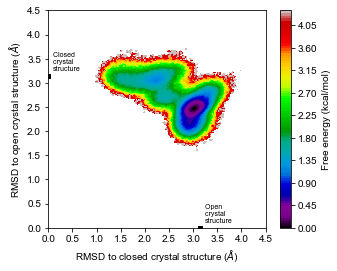

In [29]:
fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,
                              cbar=True,ncontours=100,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap3.png', dpi=600)

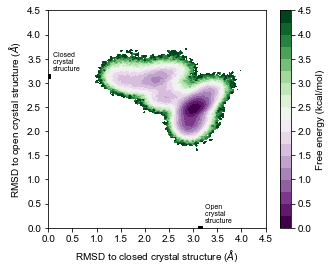

In [30]:
fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

cmap = cm.get_cmap("PRGn", 18)

pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,cmap=cmap,
                              cbar=True,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap4.png', dpi=600)

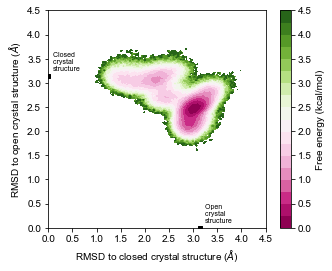

In [16]:
fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

cmap = cm.get_cmap("PiYG", 18)

pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,cmap=cmap,
                              cbar=True,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap5.png', dpi=600)

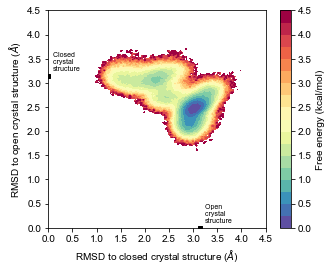

In [14]:
fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

cmap = cm.get_cmap("Spectral_r", 18)

pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,cmap=cmap,
                              cbar=True,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap6.png', dpi=600)

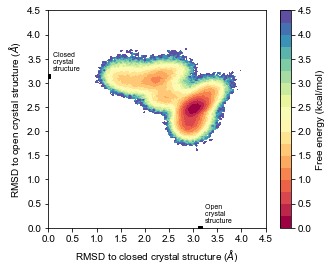

In [15]:
fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

cmap = cm.get_cmap("Spectral", 18)

pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,cmap=cmap,
                              cbar=True,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap7.png', dpi=600)

In [26]:
hexlist=[]

cmap = cm.get_cmap("Blues_r",54)    # PiYG

for i in range(0,cmap.N,3):
    rgb = cmap(i)[:3] 
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
my_cmap=ListedColormap(hexlist)
my_cmap

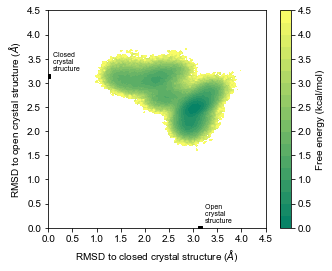

In [38]:
hexlist=[]

cmap = cm.get_cmap("Blues_r",54)    # PiYG

for i in range(0,cmap.N,3):
    rgb = cmap(i)[:3] 
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
my_cmap=ListedColormap(hexlist)

fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)


pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,cmap="summer",
                              cbar=True,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap8.png', dpi=600)

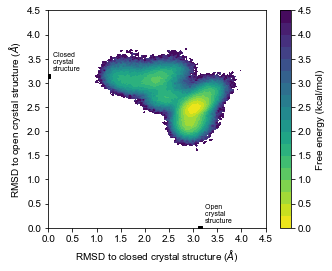

In [34]:
fig, ax = plt.subplots(figsize=(5,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, 
                              cax=cax,cmap='viridis_r',
                              cbar=True,ncontours=18,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/2_initial_FES_cmap9.png', dpi=600)

In [ ]:
list=

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(8,7), sharex=True, sharey=True)


for i, ax in enumerate(axes.flat):
    ax.scatter(Y[i][:,0], Y[i][:,1],s=0.5, marker='o',c=range(0,len(Y[i])), alpha=0.5, linewidths=0.0)
    
    ax.set_xlim(0,4.5)
    ax.set_xticks(np.arange(0, 5, 1))    
    ax.set_ylim(0,4.5)
    ax.set_yticks(np.arange(0, 5, 1))     
    ax.set_aspect('equal')

# To have common x and y labels   
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)    
plt.xlabel(r'RMSD to closed crystal structure ($\AA$)')
plt.ylabel(r'RMSD to open crystal structure ($\AA$)')

fig.savefig('./plots/2-Without_IPA/3_sampling_of_individual_trajectories.png', dpi=800)

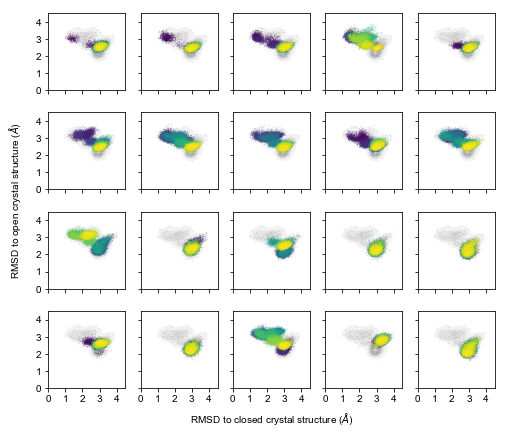

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(8,7), sharex=True, sharey=True)


for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_density(
    *Y_concat[:, :2].T, ax=ax, cbar=False, alpha=0.05, nbins=100, cmap="gray")
    ax.scatter(Y[i][:,0], Y[i][:,1],s=0.5, marker='o',linewidths=0.0,c=range(0,len(Y[i])), alpha=0.5)
    ax.set_xlim(0,4.5)
    ax.set_xticks(np.arange(0, 5, 1))    
    ax.set_ylim(0,4.5)
    ax.set_yticks(np.arange(0, 5, 1))     
    ax.set_aspect('equal')

# To have common x and y labels
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)    
plt.xlabel(r'RMSD to closed crystal structure ($\AA$)')
plt.ylabel(r'RMSD to open crystal structure ($\AA$)')

fig.tight_layout()

fig.savefig('./plots/2-Without_IPA/3_sampling_of_individual_trajectories_with_overall_FES.png', dpi=800)

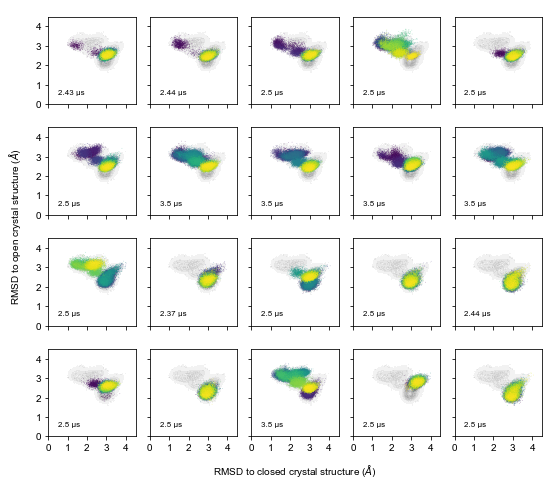

In [6]:
fig, axes = plt.subplots(4, 5, figsize=(8,7), sharex=True, sharey=True)


for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_density(
    *Y_concat[:, :2].T, ax=ax, cbar=False, alpha=0.05, nbins=100, cmap="gray")
    ax.scatter(Y[i][:,0], Y[i][:,1],s=0.5, marker='o',linewidths=0.0,c=range(0,len(Y[i])), alpha=0.5)
    ax.set_xlim(0,4.5)
    ax.set_xticks(np.arange(0, 5, 1))    
    ax.set_ylim(0,4.5)
    ax.set_yticks(np.arange(0, 5, 1))     
    
    ax.text(0.5, 0.5, '{:.3} μs'.format(len(Y[i])/10000), fontsize=8, color='k')
    ax.set_aspect('equal')

# To have common x and y labels
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)    
plt.xlabel(r'RMSD to closed crystal structure ($\AA$)')
plt.ylabel(r'RMSD to open crystal structure ($\AA$)')

fig.tight_layout()

fig.savefig('./plots/2-Without_IPA/3_sampling_of_individual_trajectories_with_overall_FES_time.png', dpi=800)

## Clustering

In [12]:
n_clustercenters = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,1200, 1400, 1600, 1800, 2000]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=True):
            _cl = pyemma.coordinates.cluster_kmeans(
                Y, k=k, max_iter=500, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

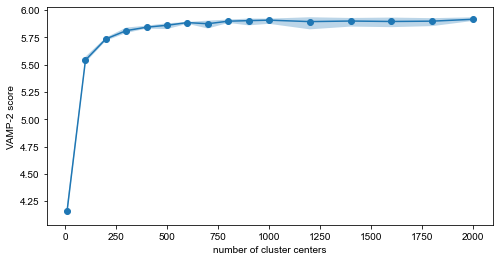

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
# ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.savefig('./plots/2-Without_IPA/4_optimum_cluster_number.png', dpi=600)

In [ ]:
fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
# ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
ax.set_xlim(300, 1600)
ax.set_ylim(5.75, 5.95)
fig.tight_layout()

In [ ]:
cluster = pyemma.coordinates.cluster_kmeans(
    Y, k=1000, max_iter=500, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

In [7]:
# with open('./pickled/2-Without_IPA/1_cluster.pickle', 'wb') as outf:
#     pickle.dump(cluster, outf)
    
with open('./pickled/2-Without_IPA/1_cluster.pickle', 'rb') as inf:
    cluster = pickle.load(inf)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

In [8]:
cluster

KmeansClustering(clustercenters=array([[2.15655, 2.71957],
       [3.04182, 2.41531],
       ...,
       [2.79853, 2.58618],
       [3.01406, 2.57222]], dtype=float32),
         fixed_seed=1769825337, init_strategy='kmeans++', keep_data=False,
         max_iter=500, metric='euclidean', n_clusters=1000, n_jobs=4,
         oom_strategy='memmap', skip=0, stride=10, tolerance=1e-05)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *Y_concat[:, :2].T, ax=ax, cbar=False, alpha=0.3, nbins=100)
ax.scatter(*cluster.clustercenters[:, :2].T, s=0.5, c='C1')
ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

ax.scatter(x=0.0, y=3.1458, s=20, c="midnightblue", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="midnightblue", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

fig.savefig('./plots/2-Without_IPA/5_clustering.png', dpi=600)

In [14]:
mylags = [1,2,5,10,25,50,100,200,300,400,500,600,700,800,900,1000,
          1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4500,5000,
          5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]

In [15]:
its = pyemma.msm.its(cluster.dtrajs, lags=mylags, nits=10, errors=None)

In [ ]:
with open('./pickled/2-Without_IPA/1_its_2000.pickle', 'wb') as outf:
    pickle.dump(its, outf)
    
# with open('./pickled/2-Without_IPA/1_its_2000.pickle', 'rb') as inf:
#     its = pickle.load(inf)

In [ ]:
its

Text(0, 0.5, 'Implied timescale (ns)')

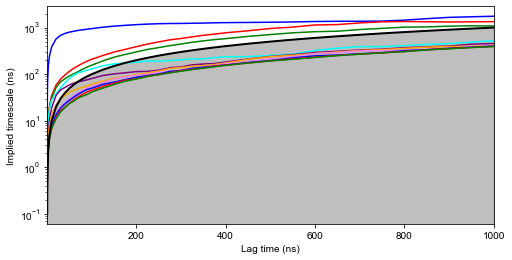

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))

pyemma.plots.plot_implied_timescales(its, ax=ax,units='ns', dt=0.1, ylog=True,);

# ax.set_xlim(0,60)
ax.set_xlabel("Lag time (ns)")
ax.set_ylabel("Implied timescale (ns)")


# fig.savefig('./plots/2-Without_IPA/6_lagtime_1.png', dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

pyemma.plots.plot_implied_timescales(its, ax=ax,units='ns', dt=0.1, ylog=False,);

ax.set_xlim(0,60)
ax.set_ylim(0,100)
ax.set_xlabel("Lag time (ns)")
ax.set_ylabel("Implied timescale (ns)")


# fig.savefig('./plots/2-Without_IPA/6_lagtime_1.png', dpi=600)

Text(0, 0.5, 'Implied timescale (ns)')

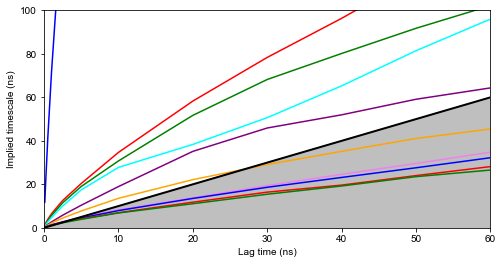

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))

pyemma.plots.plot_implied_timescales(its, ax=ax,units='ns', dt=0.1, ylog=False,);

ax.set_xlim(0,60)
ax.set_ylim(0,100)
ax.set_xlabel("Lag time (ns)")
ax.set_ylabel("Implied timescale (ns)")


# fig.savefig('./plots/2-Without_IPA/6_lagtime_1.png', dpi=600)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pyemma.plots.plot_implied_timescales(its, ax=axes[0],units='ns', dt=0.1, ylog=True,);
pyemma.plots.plot_implied_timescales(its,ax=axes[1], units='ns', dt=0.1, ylog=False);

axes[0].set_xlabel("Lag time (ns)")
axes[0].set_ylabel("Implied timescale (ns)")
axes[1].set_xlabel("Lag time (ns)")
axes[1].set_ylabel("Implied timescale (ns)")

# fig.savefig('./plots/2-Without_IPA/6_lagtime_1.png', dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, ylog=False);
ax.set(xlim=(39,41) , ylim=(25, 50))

In [ ]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=300, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

In [19]:
# with open('./pickled/2-Without_IPA/1_msm.pickle', 'wb') as outf:
#     pickle.dump(msm, outf)
    
with open('./pickled/2-Without_IPA/1_msm.pickle', 'rb') as inf:
    msm = pickle.load(inf)

In [20]:
msm

BayesianMSM(conf=0.95, connectivity='largest', core_set=None,
      count_mode='effective', dt_traj='0.1 ns', lag=300,
      milestoning_method='last_core', mincount_connectivity='1/n',
      nsamples=100, nsteps=31, reversible=True, show_progress=True,
      sparse=False, statdist_constraint=None)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

pyemma.plots.plot_contour(
    *Y_concat[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0], bins=100,
    mask=True, alpha=0.8,
    cbar_label='stationary distribution')

pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T,
    weights=None,
    ax=axes[1], bins=100,
    kT=0.5825, 
    legacy=False,#cmap='coolwarm',ncontours=18,
#     vmin=0.0, vmax=5.0,
    cbar_label="Free energy (kcal/mol)"
)

pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T, 
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[2], bins=100,
    kT=0.5825,legacy=False,#cmap='coolwarm',ncontours=21,
#     vmin=0.0, vmax=5.0, levels=100,
    cbar_label="Free energy (kcal/mol)"
)

axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Initial free energy surface', fontweight='bold')
axes[2].set_title('Reweighted free energy surface', fontweight='bold')

axes[0].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[0].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[0].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[0].set_xticks(np.arange(0, 5, 0.5))
axes[0].set_yticks(np.arange(0, 5, 0.5))

axes[1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[1].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[1].set_xticks(np.arange(0, 5, 0.5))
axes[1].set_yticks(np.arange(0, 5, 0.5))

axes[2].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[2].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[2].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[2].set_xticks(np.arange(0, 5, 0.5))
axes[2].set_yticks(np.arange(0, 5, 0.5))

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

fig.savefig('./plots/2-Without_IPA/7_free_energy_surfaces.png', dpi=600)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

pyemma.plots.plot_contour(
    *Y_concat[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0], bins=100,
    mask=True, alpha=0.8,
    cbar_label='stationary distribution')

pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T,
    weights=None,
    ax=axes[1], bins=100,
    kT=0.5825, 
    legacy=False,cmap="RdBu_r",ncontours=19,
#     vmin=0.0, vmax=5.0,
    cbar_label="Free energy (kcal/mol)"
)

pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T, 
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[2], bins=100,
    kT=0.5825,legacy=False,cmap="RdBu_r",ncontours=19,
#     vmin=0.0, vmax=5.0, levels=100,
    cbar_label="Free energy (kcal/mol)"
)

axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Initial free energy surface', fontweight='bold')
axes[2].set_title('Reweighted free energy surface', fontweight='bold')

axes[0].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[0].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[0].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[0].set_xticks(np.arange(0, 5, 0.5))
axes[0].set_yticks(np.arange(0, 5, 0.5))

axes[1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[1].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[1].set_xticks(np.arange(0, 5, 0.5))
axes[1].set_yticks(np.arange(0, 5, 0.5))

axes[2].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[2].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[2].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[2].set_xticks(np.arange(0, 5, 0.5))
axes[2].set_yticks(np.arange(0, 5, 0.5))

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

fig.savefig('./plots/2-Without_IPA/7_free_energy_surfaces_cmap2.png', dpi=600)

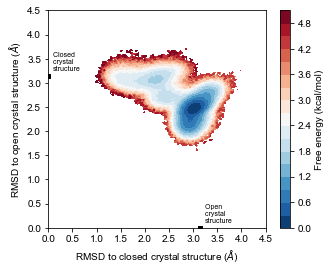

In [10]:
fig, ax = plt.subplots(figsize=(5,4))



pyemma.plots.plot_free_energy(*Y_concat[:, :2].T,
                              nbins=100, ax=ax,
                              kT=0.5825, weights=np.concatenate(msm.trajectory_weights()),
                              cbar=True,cmap="RdBu_r",ncontours=19,
                              cbar_label="Free energy (kcal/mol)")

ax.scatter(x=0.0, y=3.1458, s=20, c="black", marker="s")
ax.scatter(x=3.1458, y=0.0, s=20, c="black", marker="s")

ax.set_aspect('equal')
ax.text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
ax.text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

# fig.tight_layout()
fig.savefig('./plots//2-Without_IPA/8_reweighted_FES_cmap2.png', dpi=600)

In [29]:
cktest6 = msm.cktest(6)
pyemma.plots.plot_cktest(cktest6, dt=0.1, units='ns');

KeyboardInterrupt: 

In [ ]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')

fig.savefig('./plots/2-Without_IPA/9_its_separation.png', dpi=600)

In [ ]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *Y_concat[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    
    ax.set_xlim(0,4.5)
    ax.set_xticks(np.arange(0, 5, 0.5))
    ax.set_aspect('equal')

axes[1,0].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1,1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1,2].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1,3].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[0,0].set_ylim(0,4.5)
axes[0,0].set_yticks(np.arange(0, 5, 0.5))
axes[0,0].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[1,0].set_ylim(0,4.5)
axes[1,0].set_yticks(np.arange(0, 5, 0.5))
axes[1,0].set_ylabel(r'RMSD to open crystal structure ($\AA$)')

# fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/10_eigenvectors.png', dpi=600)

## PCCA metastable states

In [21]:
nstates=6
msm.pcca(nstates)

dtrajs_concatenated = np.concatenate(cluster.dtrajs)
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

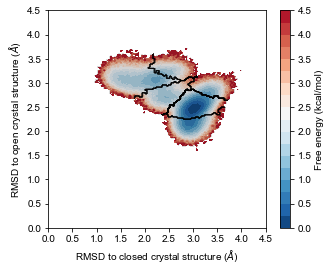

In [38]:
black_cmap = ListedColormap(["k","k","k","k","k","k"])

diverging_colors = sns.color_palette("RdBu_r", 19)
sns_cmap = ListedColormap(diverging_colors[0:18])


fig, ax = plt.subplots(figsize=(5, 4))


pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T, 
#     weights=np.concatenate(msm.trajectory_weights()),
    ax=ax, nbins=100,
    kT=0.5825, legacy=False, alpha=1, cmap=sns_cmap,
#     vmin=0.0, vmax=5.0, 
    levels=19,
    cbar_label="Free energy (kcal/mol)"
)

_, _, misc = pyemma.plots.plot_state_map(
    *Y_concat.T, metastable_traj, ax=ax, alpha=0.15, nbins=100, cbar=False,cmap=black_cmap)


ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')
ax.set_aspect('equal')
ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))

fig.savefig('./plots/2-Without_IPA/11_metastable_state_bondaries.png', dpi=600)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)

_, _, misc = pyemma.plots.plot_state_map(
    *Y_concat[:, :2].T, metastable_traj, ax=axes[0], zorder=-1, nbins=100)

misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T, 
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1], nbins=100,
    kT=0.5825, legacy=False,
#     vmin=0.0, vmax=5.0, levels=100,
    cbar_label="Free energy (kcal/mol)"
)

axes[0].set_title('Metastable states', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')

axes[0].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[0].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[0].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[0].set_xticks(np.arange(0, 5, 0.5))
axes[0].set_yticks(np.arange(0, 5, 0.5))

axes[1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[1].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[1].set_xticks(np.arange(0, 5, 0.5))
axes[1].set_yticks(np.arange(0, 5, 0.5))


axes[0].set_aspect('equal')
axes[1].set_aspect('equal')


# fig.savefig('./plots/12_metastable_states.png', dpi=600)

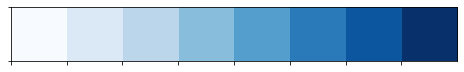

In [37]:
hexlist=[]

cmap = cm.get_cmap("Blues",8)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
sns.set_palette(hexlist)
sns.palplot(sns.color_palette())
# my_cmap=[hexlist[2],hexlist[1],hexlist[3],hexlist[4],hexlist[6],hexlist[5]]
my_cmap=ListedColormap([hexlist[3],hexlist[2],hexlist[4],hexlist[5],hexlist[7],hexlist[6]])

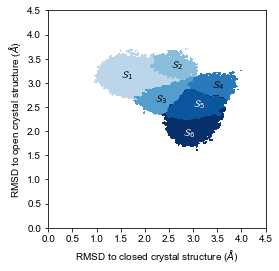

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))

_, _, misc = pyemma.plots.plot_state_map(
    *Y_concat[:, :2].T, metastable_traj, ax=ax, 
    cmap=my_cmap, cbar=False,
    zorder=-1, nbins=100)

# misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')
ax.set(xlim=(0,4.5) , ylim=(0, 4.5))
ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))
ax.set_aspect('equal')

ax.text(1.5,3.1,r'$\mathcal{S}_1$',c='k')
ax.text(2.55,3.3,r'$\mathcal{S}_2$',c='k')
ax.text(2.2,2.6,r'$\mathcal{S}_3$',c='k')
ax.text(3.4,2.9,r'$\mathcal{S}_4$',c='k')
ax.text(3.,2.5,r'$\mathcal{S}_5$',c='w' )
ax.text(2.8,1.9,r'$\mathcal{S}_6$',c='w' )

fig.savefig('./plots/2-Without_IPA/12_metastable_states.png', dpi=600)

In [ ]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 1000)

In [ ]:
traj_source = pyemma.coordinates.source(traj_list, top=topfile, stride=1)
pyemma.coordinates.save_trajs(
    traj_source,
    pcca_samples,
    outfiles=['./sample_structures/2-Without_IPA/1-MSM_1000_samples/pcca{}_samples.xtc'.format(n + 1)
              for n in range(msm.n_metastable)])

### Position metastable samples 

In [ ]:
indir_sample = './sample_structures/2-Without_IPA/1-MSM_1000_samples'
traj_list_sample = sorted(glob(indir_sample+'/*.xtc'))
traj_list_sample

In [ ]:
results_open_sample=[]
results_closed_sample=[]
for t in traj_list_sample:
    traj=pt.load(t, topfile, stride=1)
    rmsd0=pt.rmsd(traj,ref=rf0, mask="@CA,N,C,O")
    rmsd1=pt.rmsd(traj,ref=rf1, mask="@CA,N,C,O")
    rmsd2=pt.rmsd(traj,ref=rf2, mask="@CA,N,C,O")
    rmsd3=pt.rmsd(traj,ref=rf3, mask="@CA,N,C,O")
    rmsd4=pt.rmsd(traj,ref=rf4, mask="@CA,N,C,O")
    rmsd5=pt.rmsd(traj,ref=rf5, mask="@CA,N,C,O")
    
    rmsd_closed=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)
    results_closed_sample.append(rmsd_closed)
    
    rmsd_open=pt.rmsd(traj,ref=rfopen, mask="@CA,N,C,O")
    results_open_sample.append(rmsd_open)

In [ ]:
rmsd_open_sample=np.concatenate(results_open_sample, axis=0)
rmsd_closed_sample=np.concatenate(results_closed_sample, axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T, 
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax, nbins=100,
    kT=0.5825, 
    cbar=False
)

ax.plot(rmsd_closed_sample, rmsd_open_sample, linewidth=0, marker='o', markersize=0.5, color='white')

ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')
ax.set_aspect('equal')

fig.savefig('./plots/1-With_IPA/13_sample_structures.png', dpi=600)

## MFPT

In [28]:
p=[]
print('state\tπ\tΔG(kcal/mol)')
for i, s in enumerate(msm.metastable_sets):
    p.append(msm.pi[s].sum())
    
labels=[2,1,3,4,6,5]
for j in range(0,6):

    print('{}\t{:.3f}\t{:.3f}'.format(labels[j],p[j], (-0.5825*np.log(p[j])+0.5825*np.log(p[5]))))


state	π	ΔG(kcal/mol)
2	0.018	2.067
1	0.074	1.241
3	0.040	1.599
4	0.053	1.436
6	0.196	0.672
5	0.620	0.000


In [33]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / μs:')
DataFrame(np.round(mfpt/1000, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / μs:


,1,2,3,4,5,6
1,0.00,0.20,0.73,1.97,1.29,0.87
2,3.46,0.00,0.69,1.91,1.22,0.81
3,6.42,2.95,0.00,1.62,0.94,0.51
4,9.87,6.35,3.53,0.00,0.48,0.09
5,10.03,6.52,3.70,1.34,0.00,0.09
6,9.95,6.43,3.60,1.24,0.39,0.00


Already in ns because msm was created with option `dt_traj='0.1 ns'`

In [34]:
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [17]:
stat_dist=[]
for i, s in enumerate(msm.metastable_sets):
    stat_dist.append(msm.pi[s].sum())
print(np.array(stat_dist))

[0.01785633 0.07371517 0.03986538 0.05269302 0.19561282 0.62025729]


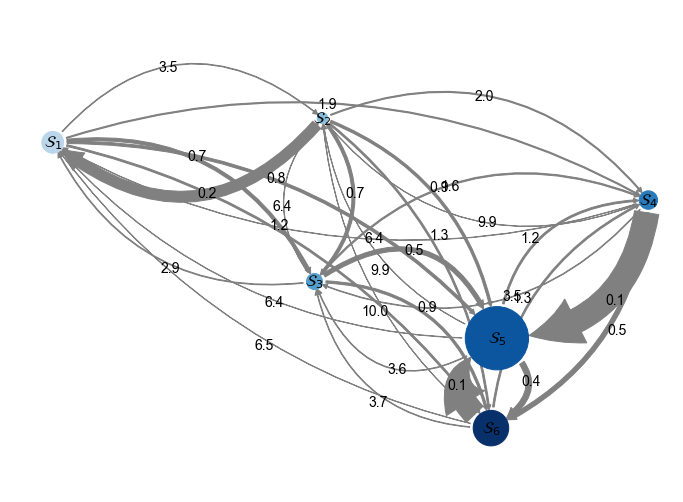

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f',
    arrow_labels=mfpt/1000,
    size=16,
    state_colors=[hexlist[3],hexlist[2],hexlist[4],hexlist[5],hexlist[7],hexlist[6]],
    state_labels=[r'$\mathcal{S}_2$',r'$\mathcal{S}_1$',r'$\mathcal{S}_3$',
                  r'$\mathcal{S}_4$',r'$\mathcal{S}_6$',r'$\mathcal{S}_5$'],
    state_sizes=np.array(stat_dist),
    arrow_scale=6.0, arrow_curvature=3,
    show_frame=False,
    arrow_label_size=14,
    fontweight='bold',
    ax=ax)

# ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
# ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')
ax.set(xlim=(1.5,3.5) , ylim=(2.0,3.25))
# ax.set_xticks(np.arange(2, 4.5, 0.5))
# ax.set_yticks(np.arange(1.5, 4, 0.5))
ax.set_aspect('equal')

fig.savefig('./plots/2-Without_IPA/14_MFPT.png', dpi=600)